# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import cPickle as pickle
import numpy as np
import os
from scipy.misc import imread

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = pickle.load(f)
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte

def load_tiny_imagenet(path, dtype=np.float32):
  """
  Load TinyImageNet. Each of TinyImageNet-100-A, TinyImageNet-100-B, and
  TinyImageNet-200 have the same directory structure, so this can be used
  to load any of them.

  Inputs:
  - path: String giving path to the directory to load.
  - dtype: numpy datatype used to load the data.

  Returns: A tuple of
  - class_names: A list where class_names[i] is a list of strings giving the
    WordNet names for class i in the loaded dataset.
  - X_train: (N_tr, 3, 64, 64) array of training images
  - y_train: (N_tr,) array of training labels
  - X_val: (N_val, 3, 64, 64) array of validation images
  - y_val: (N_val,) array of validation labels
  - X_test: (N_test, 3, 64, 64) array of testing images.
  - y_test: (N_test,) array of test labels; if test labels are not available
    (such as in student code) then y_test will be None.
  """
  # First load wnids
  with open(os.path.join(path, 'wnids.txt'), 'r') as f:
    wnids = [x.strip() for x in f]

  # Map wnids to integer labels
  wnid_to_label = {wnid: i for i, wnid in enumerate(wnids)}

  # Use words.txt to get names for each class
  with open(os.path.join(path, 'words.txt'), 'r') as f:
    wnid_to_words = dict(line.split('\t') for line in f)
    for wnid, words in wnid_to_words.iteritems():
      wnid_to_words[wnid] = [w.strip() for w in words.split(',')]
  class_names = [wnid_to_words[wnid] for wnid in wnids]

  # Next load training data.
  X_train = []
  y_train = []
  for i, wnid in enumerate(wnids):
    if (i + 1) % 20 == 0:
      print 'loading training data for synset %d / %d' % (i + 1, len(wnids))
    # To figure out the filenames we need to open the boxes file
    boxes_file = os.path.join(path, 'train', wnid, '%s_boxes.txt' % wnid)
    with open(boxes_file, 'r') as f:
      filenames = [x.split('\t')[0] for x in f]
    num_images = len(filenames)
    
    X_train_block = np.zeros((num_images, 3, 64, 64), dtype=dtype)
    y_train_block = wnid_to_label[wnid] * np.ones(num_images, dtype=np.int64)
    for j, img_file in enumerate(filenames):
      img_file = os.path.join(path, 'train', wnid, 'images', img_file)
      img = imread(img_file)
      if img.ndim == 2:
        ## grayscale file
        img.shape = (64, 64, 1)
      X_train_block[j] = img.transpose(2, 0, 1)
    X_train.append(X_train_block)
    y_train.append(y_train_block)
      
  # We need to concatenate all training data
  X_train = np.concatenate(X_train, axis=0)
  y_train = np.concatenate(y_train, axis=0)
  
  # Next load validation data
  with open(os.path.join(path, 'val', 'val_annotations.txt'), 'r') as f:
    img_files = []
    val_wnids = []
    for line in f:
      img_file, wnid = line.split('\t')[:2]
      img_files.append(img_file)
      val_wnids.append(wnid)
    num_val = len(img_files)
    y_val = np.array([wnid_to_label[wnid] for wnid in val_wnids])
    X_val = np.zeros((num_val, 3, 64, 64), dtype=dtype)
    for i, img_file in enumerate(img_files):
      img_file = os.path.join(path, 'val', 'images', img_file)
      img = imread(img_file)
      if img.ndim == 2:
        img.shape = (64, 64, 1)
      X_val[i] = img.transpose(2, 0, 1)

  # Next load test images
  # Students won't have test labels, so we need to iterate over files in the
  # images directory.
  img_files = os.listdir(os.path.join(path, 'test', 'images'))
  X_test = np.zeros((len(img_files), 3, 64, 64), dtype=dtype)
  for i, img_file in enumerate(img_files):
    img_file = os.path.join(path, 'test', 'images', img_file)
    img = imread(img_file)
    if img.ndim == 2:
      img.shape = (64, 64, 1)
    X_test[i] = img.transpose(2, 0, 1)

  y_test = None
  y_test_file = os.path.join(path, 'test', 'test_annotations.txt')
  if os.path.isfile(y_test_file):
    with open(y_test_file, 'r') as f:
      img_file_to_wnid = {}
      for line in f:
        line = line.split('\t')
        img_file_to_wnid[line[0]] = line[1]
    y_test = [wnid_to_label[img_file_to_wnid[img_file]] for img_file in img_files]
    y_test = np.array(y_test)
  
  return class_names, X_train, y_train, X_val, y_val, X_test, y_test


def load_models(models_dir):
  """
  Load saved models from disk. This will attempt to unpickle all files in a
  directory; any files that give errors on unpickling (such as README.txt) will
  be skipped.

  Inputs:
  - models_dir: String giving the path to a directory containing model files.
    Each model file is a pickled dictionary with a 'model' field.

  Returns:
  A dictionary mapping model file names to models.
  """
  models = {}
  for model_file in os.listdir(models_dir):
    with open(os.path.join(models_dir, model_file), 'rb') as f:
      try:
        models[model_file] = pickle.load(f)['model']
      except pickle.UnpicklingError:
        continue
  return models

In [2]:
# Run some setup code for this notebook.

import random
import numpy as np
#from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'D:/data/winter1516_assignment1/assignment1/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Training data shape:  (50000L, 32L, 32L, 3L)
Training labels shape:  (50000L,)
Test data shape:  (10000L, 32L, 32L, 3L)
Test labels shape:  (10000L,)


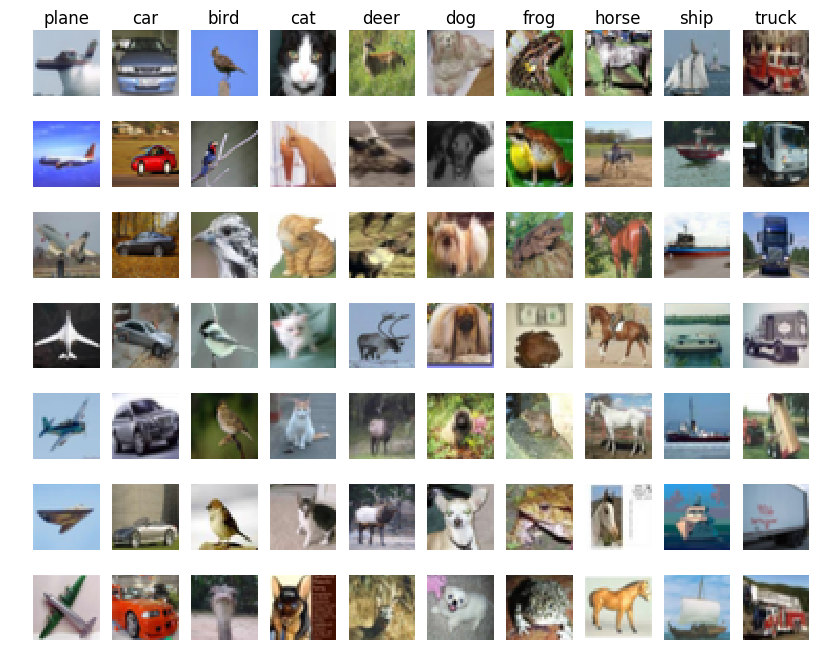

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (49000L, 32L, 32L, 3L)
Train labels shape:  (49000L,)
Validation data shape:  (1000L, 32L, 32L, 3L)
Validation labels shape:  (1000L,)
Test data shape:  (1000L, 32L, 32L, 3L)
Test labels shape:  (1000L,)


In [6]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print 'Training data shape: ', X_train.shape
print 'Validation data shape: ', X_val.shape
print 'Test data shape: ', X_test.shape
print 'dev data shape: ', X_dev.shape

Training data shape:  (49000L, 3072L)
Validation data shape:  (1000L, 3072L)
Test data shape:  (1000L, 3072L)
dev data shape:  (500L, 3072L)


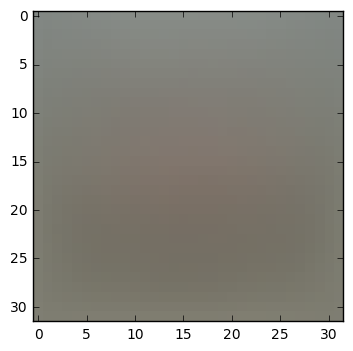

In [7]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
#print mean_image[:50] # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [8]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [10]:
#print(X_train)


In [9]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
# Also, lets transform both data matrices so that each image is a column.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]).T
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))]).T
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]).T
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))]).T

print X_train.shape, X_val.shape, X_test.shape, X_dev.shape

(3073L, 49000L) (3073L, 1000L) (3073L, 1000L) (3073L, 500L)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [10]:
import numpy as np
from random import shuffle

def svm_loss_naive(W, X, y, reg):
    
    """
    Structured SVM loss function, naive implementation (with loops).

    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
  
    dW = np.zeros(W.shape) 
    # initialize the gradient as zero
    # compute the loss and the gradient
    num_classes = W.shape[0]
    num_train = X.shape[1]
    loss = 0.0
    for i in xrange(num_train):
        scores = W.dot(X[:,i]) 
        correct_class_score = scores[y[i]]
        for j in xrange(num_classes):
            if j == y[i]:
                continue
            margin = scores[j] - correct_class_score + 1 # note delta = 1
            if margin > 0:
                loss += margin
                dW[y[i],:] -= X[:,i].T # this is really a sum over j != y_i
                dW[j,:] += X[:,i].T # sums each contribution of the x_i's
        # Right now the loss is a sum over all training examples, but we want it
        # to be an average instead so we divide by num_train.
    loss /= num_train
    dW /= num_train

    # Add regularization to the loss and gradient.
    loss += 0.5 * reg * np.sum(W * W)
    dW += reg*W
    #############################################################################
    # TODO:                                                                     #
    # Compute the gradient of the loss function and store it dW.                #
    # Rather that first computing the loss and then computing the derivative,   #
    # it may be simpler to compute the derivative at the same time that the     #
    # loss is being computed. As a result you may need to modify some of the    #
    # code above to compute the gradient.                                       #
    # ####################  IMPLEMENTED  ########################################
    #############################################################################
    
    return loss, dW


In [11]:
# Evaluate the naive implementation of the loss we provided for you:
#from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(10, 3073) * 0.0001 

loss, grad = svm_loss_naive(W, X_train, y_train, 0.0001)
print 'loss: %f' % (loss, )

loss: 9.413985


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [12]:
from random import randrange
def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
  """
  sample a few random elements and only return numerical
  in this dimensions.
  """

  for i in xrange(num_checks):
    ix = tuple([randrange(m) for m in x.shape])

    oldval = x[ix]
    x[ix] = oldval + h # increment by h
    fxph = f(x) # evaluate f(x + h)
    x[ix] = oldval - h # increment by h
    fxmh = f(x) # evaluate f(x - h)
    x[ix] = oldval # reset

    grad_numerical = (fxph - fxmh) / (2 * h)
    grad_analytic = analytic_grad[ix]
    rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
    print 'numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error)


In [13]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
#from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -19.816381 analytic: -19.789070, relative error: 6.895680e-04
numerical: 3.805647 analytic: 3.803475, relative error: 2.854174e-04
numerical: -5.933975 analytic: -5.933975, relative error: 3.102920e-11
numerical: 1.536744 analytic: 1.536744, relative error: 1.303765e-10
numerical: 22.300939 analytic: 22.300939, relative error: 4.775411e-12
numerical: 21.923332 analytic: 21.918714, relative error: 1.053313e-04
numerical: 13.316929 analytic: 13.316929, relative error: 9.279203e-12
numerical: 16.285065 analytic: 16.285065, relative error: 2.072063e-12
numerical: -3.248143 analytic: -3.248143, relative error: 1.580250e-10
numerical: 2.397427 analytic: 2.397427, relative error: 6.564800e-11
numerical: -6.539782 analytic: -6.539782, relative error: 6.196738e-11
numerical: -20.459660 analytic: -20.428556, relative error: 7.607072e-04
numerical: -12.410461 analytic: -12.337929, relative error: 2.930757e-03
numerical: -0.978106 analytic: -0.978106, relative error: 1.244096e-10
numeri

In [14]:
loss, grad = svm_loss_naive(W, X_dev, y_dev, 1e2)
print 'loss: %f' % (loss, )

loss: 9.312743


### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In [15]:
def svm_loss_vectorized(W, X, y, reg):
    
    loss = 0.0
    dW = np.zeros(W.shape) # initialize the gradient as zero

    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the structured SVM loss, storing the    #
    # result in loss.                                                           #
    #############################################################################
    D = X.shape[0]
    num_classes = W.shape[0]
    num_train = X.shape[1]
    scores = W.dot(X)

    correct_scores = scores[y, np.arange(num_train)] 

    mat = scores - correct_scores + 1 
    mat[y, np.arange(num_train)] = 0 

    thresh = np.maximum(np.zeros((num_classes,num_train)), mat)
    loss = np.sum(thresh)
    loss /= num_train
    loss += 0.5 * reg * np.sum(W * W)
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################


    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the gradient for the structured SVM     #
    # loss, storing the result in dW.                                           #
    #                                                                           #
    # Hint: Instead of computing the gradient from scratch, it may be easier    #
    # to reuse some of the intermediate values that you used to compute the     #
    # loss.                                                                     #
    #############################################################################
    # Binarize into integers
    binary = thresh
    binary[thresh > 0] = 1

    # Perform the two operations simultaneously
    # (1) for all j: dW[j,:] = sum_{i, j produces positive margin with i} X[:,i].T
    # (2) for all i: dW[y[i],:] = sum_{j != y_i, j produces positive margin with i} -X[:,i].T
    col_sum = np.sum(binary, axis=0)
    binary[y, range(num_train)] = -col_sum[range(num_train)]
    dW = np.dot(binary, X.T)

    # Divide
    dW /= num_train

    # Regularize
    dW += reg*W

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

    return loss, dW


In [16]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_train, y_train, 0.00001)
toc = time.time()
print 'Naive loss: %e computed in %fs' % (loss_naive, toc - tic)

#from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_train, y_train, 0.00001)
toc = time.time()
print 'Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# The losses should match but your vectorized implementation should be much faster.
print 'difference: %f' % (loss_naive - loss_vectorized)

Naive loss: 9.413985e+00 computed in 4.095000s
Vectorized loss: 9.413985e+00 computed in 0.202000s
difference: -0.000000


In [33]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Naive loss and gradient: computed in %fs' % (toc - tic)

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Vectorized loss and gradient: computed in %fs' % (toc - tic)

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'difference: %f' % difference

Naive loss and gradient: computed in 0.047000s
Vectorized loss and gradient: computed in 0.003000s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [ ]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print 'That took %fs' % (toc - tic)

In [ ]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [ ]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print 'training accuracy: %f' % (np.mean(y_train == y_train_pred), )
y_val_pred = svm.predict(X_val)
print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )

In [ ]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [5e4, 1e5]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

In [ ]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [ ]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'linear SVM on raw pixels final test set accuracy: %f' % test_accuracy

In [ ]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*